In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pathlib import Path

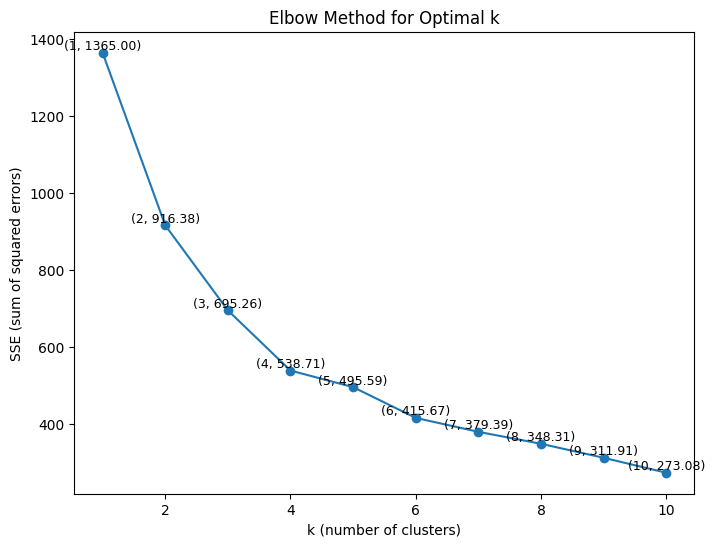

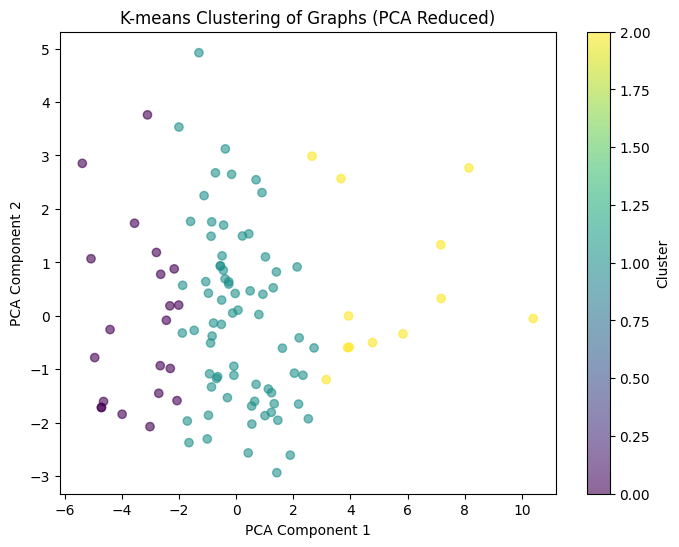

K-means clustering with k=3 completed, combined data prepared.
Combined data saved to Excel file with separate sheets (each cluster and a summary sheet) at /home/zceeag0/quantum_repeaters_testing/new_result/k_mean_results(k=3).xlsx


In [8]:
# 1. Load data
xlsx_path = Path.cwd().parent.joinpath("new_result", "SR_results.xlsx")
sheets = ["class_0", "class_1", "class_2"]
df_list = []
for sheet in sheets:
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    df_list.append(df)
data = pd.concat(df_list, ignore_index=True)

# 2. Select features (exclude non-numeric columns)
features = [
    "n", "m", "mpc_avg","mpg_avg","sp_avg","avg_degree", "diameter", "density", 
    "avg_shortest_path", "avg_clustering","global_efficiency","spectral_radius", 
    "algebraic_connectivity"
]
X = data[features]

# 3. Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Use Elbow Technique to determine the optimal number of clusters
sse = []
k_range = range(1, 11)  # Try 1 to 10 clusters
for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(X_scaled)
    sse.append(kmeans_temp.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
# Annotate each point with (k, SSE)
for k, error in zip(k_range, sse):
    plt.text(k, error, f"({k}, {error:.2f})", ha="center", va="bottom", fontsize=9)
plt.xlabel("k (number of clusters)")
plt.ylabel("SSE (sum of squared errors)")
plt.title("Elbow Method for Optimal k")
plt.show()

# (Based on the plot, suppose we choose k=3)

# 5. Use k=3 for K-means clustering
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 6. PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis", alpha=0.6)
plt.title("K-means Clustering of Graphs (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

# 7. Combine clustering results and PCA coordinates with original data
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters
combined_df = pd.concat([data.reset_index(drop=True), pca_df], axis=1)
print("K-means clustering with k=3 completed, combined data prepared.")

# 8. Save the combined data into one Excel file with separate sheets:
#    one sheet for each cluster and one additional sheet for the summary (mean of features for each cluster)
result_path = Path.cwd().parent.joinpath("new_result", f"k_mean_results(k={optimal_k}).xlsx")
with pd.ExcelWriter(result_path, engine='openpyxl') as writer:
    # Save each cluster's data in separate sheets
    for cluster, group in combined_df.groupby("Cluster"):
        sheet_name = f"Cluster_{cluster}"
        group.to_excel(writer, sheet_name=sheet_name, index=False)
    # Calculate the mean of each feature for each cluster (summary)
    grouped_means = combined_df.groupby("Cluster")[features].mean().reset_index()
    grouped_means.to_excel(writer, sheet_name="Summary", index=False)
    
print("Combined data saved to Excel file with separate sheets (each cluster and a summary sheet) at", result_path)
